In [1]:
!pip install yfinance

[*********************100%***********************]  1 of 1 completed


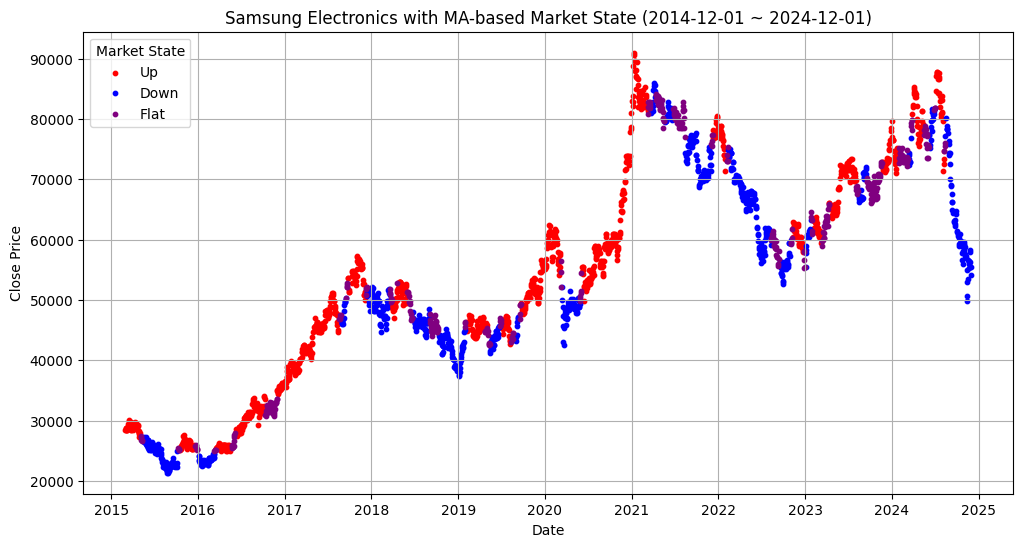

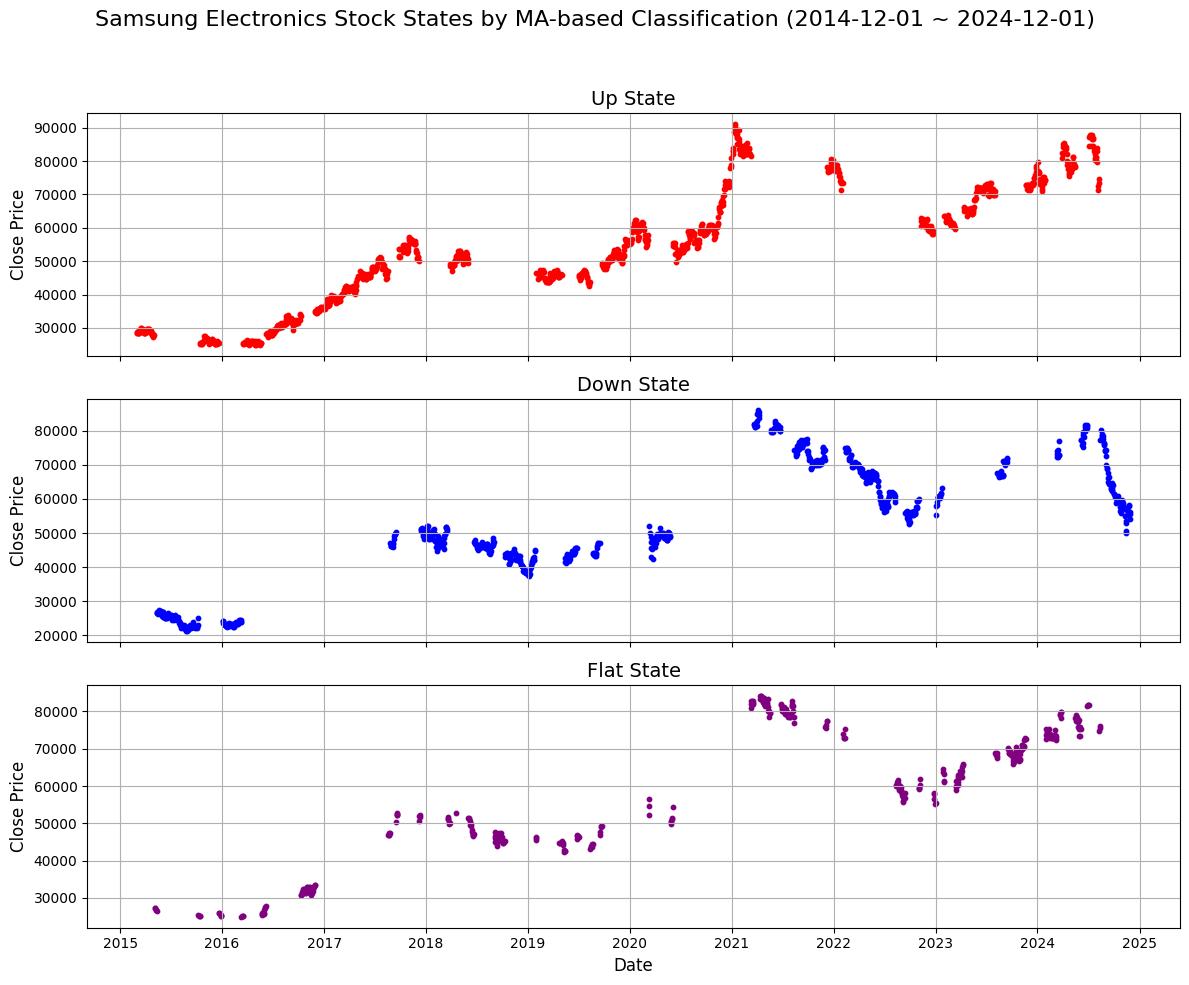

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# 1. 데이터 다운로드
ticker = '005930.KS'
start_date = "2014-12-01"
end_date = "2024-12-01"
df = yf.download(ticker, start=start_date, end=end_date)

# 이동평균 계산 (단기:20일, 장기:60일)
df['Short_MA'] = df['Close'].rolling(window=20).mean()
df['Long_MA'] = df['Close'].rolling(window=60).mean()

# NaN 제거
df.dropna(inplace=True)

# 기준값 설정
threshold_up = 0.01    # 1%
threshold_down = -0.01 # -1%

# ratio 계산
df['ratio'] = (df['Short_MA'] - df['Long_MA']) / df['Long_MA']

# 상태 결정
df['Market_State'] = df['ratio'].apply(lambda x: 'Up' if x >= threshold_up else ('Down' if x <= threshold_down else 'Flat'))

color_map = {
    'Up': 'red',
    'Down': 'blue',
    'Flat': 'purple'
}

# ---------------------------
# 전체 상태를 시각화
# ---------------------------
plt.figure(figsize=(12,6))
plt.title("Samsung Electronics with MA-based Market State (2014-12-01 ~ 2024-12-01)")
plt.xlabel("Date")
plt.ylabel("Close Price")

for state, color in color_map.items():
    state_df = df[df['Market_State'] == state]
    plt.scatter(state_df.index, state_df['Close'], color=color, s=10, label=state)

plt.legend(title="Market State")
plt.grid(True)
plt.show()

# ---------------------------
# 상태별로 분리하여 시각화
# ---------------------------
states = ['Up', 'Down', 'Flat']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
fig.suptitle("Samsung Electronics Stock States by MA-based Classification (2014-12-01 ~ 2024-12-01)", fontsize=16)

for ax, state in zip(axes, states):
    state_df = df[df['Market_State'] == state]
    ax.scatter(state_df.index, state_df['Close'], color=color_map[state], s=10)
    ax.set_title(f"{state} State", fontsize=14)
    ax.set_ylabel("Close Price", fontsize=12)
    ax.grid(True)

# 마지막 서브플롯에만 x축 라벨 표시
axes[-1].set_xlabel("Date", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Epoch [1/50] - D_loss: -0.0003, G_loss: -0.0072
Epoch [2/50] - D_loss: -0.0101, G_loss: -0.0049
Epoch [3/50] - D_loss: -0.0472, G_loss: 0.0094
Epoch [4/50] - D_loss: -0.0710, G_loss: 0.0183
Epoch [5/50] - D_loss: -0.0814, G_loss: 0.0162
Epoch [6/50] - D_loss: -0.0795, G_loss: 0.0155
Epoch [7/50] - D_loss: -0.0725, G_loss: 0.0160
Epoch [8/50] - D_loss: -0.0640, G_loss: 0.0060
Epoch [9/50] - D_loss: -0.0578, G_loss: 0.0011
Epoch [10/50] - D_loss: -0.0465, G_loss: -0.0062
Epoch [11/50] - D_loss: -0.0399, G_loss: -0.0112
Epoch [12/50] - D_loss: -0.0297, G_loss: -0.0209
Epoch [13/50] - D_loss: -0.0224, G_loss: -0.0287
Epoch [14/50] - D_loss: -0.0133, G_loss: -0.0350
Epoch [15/50] - D_loss: 0.0009, G_loss: -0.0448
Epoch [16/50] - D_loss: 0.0092, G_loss: -0.0765
Epoch [17/50] - D_loss: 0.0097, G_loss: -0.0854
Epoch [18/50] - D_loss: 0.0070, G_loss: -0.0644
Epoch [19/50] - D_loss: 0.0034, G_loss: -0.0332
Epoch [20/50] - D_loss: -0.0064, G_loss: 0.0186
Epoch [21/50] - D_loss: -0.0125, G_loss: 0

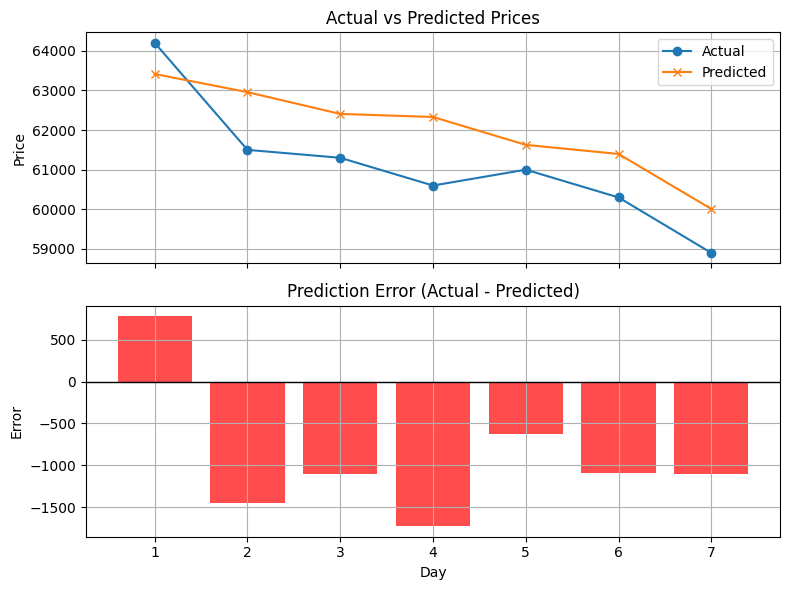

In [8]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

############################
state_map = {'Up':0,'Down':1,'Flat':2}
############################

# 기간 설정 (학습: ~2024-09-26, 예측: 2024-09-27~1주)
train_end = datetime.datetime(2024,9,26)
train_df = df[df.index <= train_end]

test_start = datetime.datetime(2024,9,27)
test_df = df[df.index >= test_start]

seq_len = 30
feature_dim = 1
noise_dim = 5
state_dim = 3
input_dim = noise_dim + 1
hidden_dim = 16
batch_size = 16
num_epochs = 50
n_critic = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_close = df['Close'].values
returns = (all_close[1:] - all_close[:-1]) / all_close[:-1]
all_states = df['Market_State'].values[1:]

train_mask = df.index[1:] <= train_end
train_returns = returns[train_mask]
train_states_list = all_states[train_mask]

scaler = MinMaxScaler((0,1))
train_returns_reshape = train_returns.reshape(-1,1)
scaler.fit(train_returns_reshape)
train_returns_scaled = scaler.transform(train_returns_reshape).ravel()

train_windows = []
train_states_idx = []
for i in range(len(train_returns_scaled)-seq_len):
    window = train_returns_scaled[i:i+seq_len]
    state_label = train_states_list[i+seq_len-1]
    train_windows.append(window)
    train_states_idx.append(state_map[state_label])

train_windows = torch.tensor(train_windows, dtype=torch.float).unsqueeze(-1) # (N,30,1)
train_states_idx = torch.tensor(train_states_idx, dtype=torch.long)
total_samples = train_windows.size(0)

train_windows = train_windows.to(device)
train_states_idx = train_states_idx.to(device)

class LSTMWithAttentionGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, state_dim, seq_len, feature_dim=1):
        super(LSTMWithAttentionGenerator, self).__init__()
        self.default_seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.feature_dim = feature_dim
        self.state_embedding = nn.Embedding(num_embeddings=3, embedding_dim=state_dim)
        self.lstm = nn.LSTM(input_dim + state_dim, hidden_dim, batch_first=True)
        self.query_linear = nn.Linear(hidden_dim + state_dim, hidden_dim)
        self.key_linear = nn.Linear(hidden_dim, hidden_dim)
        self.value_linear = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, feature_dim)

    def forward(self, noise, states, last_day_price, seq_len=None):
        if seq_len is None:
            seq_len = self.default_seq_len
        state_emb = self.state_embedding(states)
        state_emb_expanded = state_emb.unsqueeze(1).expand(-1, seq_len, -1)
        x_input = torch.cat([noise, last_day_price], dim=2)
        lstm_input = torch.cat([x_input, state_emb_expanded], dim=2)
        h_out, (h_n, c_n) = self.lstm(lstm_input)
        h_last = h_n.squeeze(0)
        Q = self.query_linear(torch.cat([h_last, state_emb], dim=1))
        K = self.key_linear(h_out)
        V = self.value_linear(h_out)
        scores = torch.matmul(Q.unsqueeze(1), K.transpose(1,2))
        attn_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, V).squeeze(1)
        context_expanded = context.unsqueeze(1).expand(-1, seq_len, -1)
        final_output = self.fc_out(h_out + context_expanded)
        return final_output

class CNNDiscriminator(nn.Module):
    def __init__(self, input_channels=1, seq_len=30, hidden_channels=32):
        super(CNNDiscriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels*2, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(in_channels=hidden_channels*2, out_channels=hidden_channels*4, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 1)
        )
    def forward(self, x):
        x = x.permute(0,2,1)
        out = self.conv_layers(x)
        out = self.fc(out)
        return out

G = LSTMWithAttentionGenerator(input_dim=input_dim, hidden_dim=hidden_dim, state_dim=state_dim, seq_len=seq_len, feature_dim=feature_dim).to(device)
D = CNNDiscriminator(input_channels=feature_dim, seq_len=seq_len, hidden_channels=32).to(device)

optimizer_G = optim.RMSprop(G.parameters(), lr=0.00005)
optimizer_D = optim.RMSprop(D.parameters(), lr=0.00005)
clip_value = 0.01

d_losses = []
g_losses = []

for epoch in range(num_epochs):
    i = 0
    d_loss_val = None
    g_loss_val = None
    while i+batch_size <= total_samples:
        # Critic update
        for _ in range(n_critic):
            if i+batch_size > total_samples:
                break
            real_data = train_windows[i:i+batch_size]
            real_states = train_states_idx[i:i+batch_size]

            D.zero_grad()
            noise = torch.randn(batch_size, seq_len, noise_dim, device=device)
            last_price_train = real_data[:, -1:, :].expand(-1, seq_len, -1)
            fake_data = G(noise, real_states, last_price_train, seq_len=seq_len)
            critic_real = D(real_data)
            critic_fake = D(fake_data.detach())
            d_loss = -(torch.mean(critic_real) - torch.mean(critic_fake))
            d_loss.backward()
            optimizer_D.step()

            for p in D.parameters():
                p.data.clamp_(-clip_value, clip_value)

            i += batch_size

        # Generator update
        G.zero_grad()
        noise = torch.randn(batch_size, seq_len, noise_dim, device=device)
        # 여기도 last_price_train을 동일하게 사용
        last_price_train = real_data[:, -1:, :].expand(-1, seq_len, -1)
        fake_data = G(noise, real_states, last_price_train, seq_len=seq_len)
        critic_fake = D(fake_data)
        g_loss = -torch.mean(critic_fake)
        g_loss.backward()
        optimizer_G.step()

        d_loss_val = d_loss.item()
        g_loss_val = g_loss.item()

    if d_loss_val is not None and g_loss_val is not None:
        d_losses.append(d_loss_val)
        g_losses.append(g_loss_val)
        print(f"Epoch [{epoch+1}/{num_epochs}] - D_loss: {d_loss_val:.4f}, G_loss: {g_loss_val:.4f}")

print("Training completed.")

# 예측 부분
focus_state = 'Down'
focus_state_idx = torch.tensor([state_map[focus_state]], dtype=torch.long, device=device)

# 마지막 관측가 (9월 26일 종가)
last_day_price_value = df.loc[df.index==datetime.datetime(2024,9,26),'Close'].values[0]

G.eval()
pred_future_returns = []
current_price = last_day_price_value
for day in range(7):
    noise_input = torch.randn(1, seq_len, noise_dim, device=device)
    last_price_input = torch.zeros((1,seq_len,1),device=device)
    pred_seq = G(noise_input, focus_state_idx, last_price_input, seq_len=seq_len)
    pred_return_scaled = pred_seq[0,-1,0].item() # 마지막 day's returns
    r_inv = scaler.inverse_transform([[pred_return_scaled]])[0,0]
    pred_future_returns.append(r_inv)
    current_price = current_price*(1+r_inv)

future_7_prices = []
cp = last_day_price_value
for r in pred_future_returns:
    cp = cp*(1+r)
    future_7_prices.append(cp)

actual_future_raw = test_df['Close'].values[:7]

# ensure 1D
actual_future_raw = np.array(actual_future_raw).ravel()
future_7_prices = np.array(future_7_prices).ravel()

mse = mean_squared_error(actual_future_raw, future_7_prices)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# 예측값과 실제값 차이 시각화
days = np.arange(1, len(actual_future_raw)+1)
errors = actual_future_raw - future_7_prices

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)

# 상단 그래프: 실제 vs 예측
axes[0].plot(days, actual_future_raw, marker='o', label='Actual')
axes[0].plot(days, future_7_prices, marker='x', label='Predicted')
axes[0].set_title("Actual vs Predicted Prices")
axes[0].set_ylabel("Price")
axes[0].legend()
axes[0].grid(True)

# 하단 그래프: 오차(Actual - Predicted)
axes[1].bar(days, errors, color='red', alpha=0.7)
axes[1].axhline(y=0, color='black', linewidth=1)
axes[1].set_title("Prediction Error (Actual - Predicted)")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Error")
axes[1].grid(True)

plt.tight_layout()
plt.show()